In [ ]:
using Pkg
Pkg.add(["Plots", "LinearAlgebra", "LaTeXStrings"])

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`


Calculated KAPPA_MAG: 0.0006933655793381856
--- Simulating Three-Wave Mixing Dynamics using IPM1 Predictor ---
Running scenario: Case 1: QPM for Higher Order SHG (Λ=7.20 μm)... (Corrector: false, Method: IPM1)
 -> Completed in 0.0011 s. (Calculated 1807 points)
Running scenario: Case 2: QPM for SFG (Λ≈1.96 μm)... (Corrector: false, Method: IPM1)
 -> Completed in 0.0061 s. (Calculated 10210 points)
Running scenario: Case 3: Cascaded QPM for THG... (Corrector: false, Method: IPM1)
 -> Completed in 0.0017 s. (Calculated 3008 points)

Generating plots...
Done.


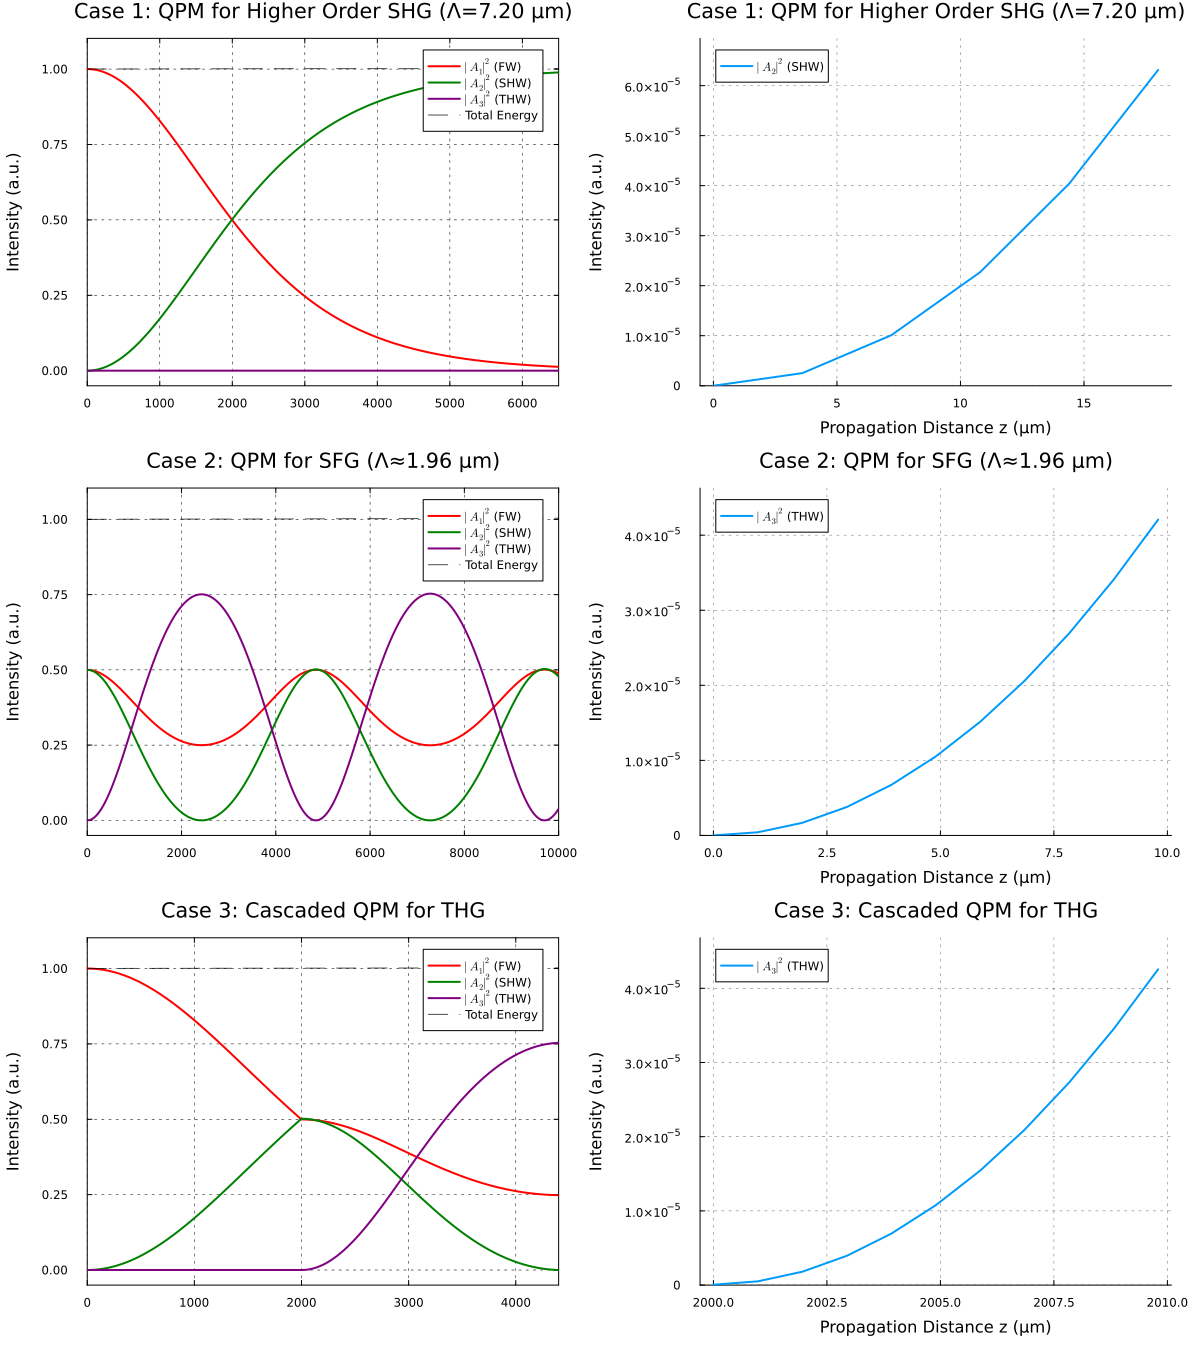

In [ ]:
using LinearAlgebra
using Plots
using LaTeXStrings
using Printf

# --- Configuration Parameters ---
# 長さ2000のデバイスでSHG効率が95%となるKAPPAを逆算
const KAPPA_MAG = atanh(sqrt(0.95)) / 2000 * 2 / pi
println("Calculated KAPPA_MAG: ", KAPPA_MAG)

# --- Helper Functions for the B Frame Transformation ---
get_L(delta_k1, delta_k2) = 1im .* [0.0, delta_k1, delta_k1 + delta_k2]

function A_from_B(B::AbstractVector{<:Complex}, z::Float64, delta_k1::Float64, delta_k2::Float64)
    B1, B2, B3 = B
    A1 = B1
    A2 = B2 * exp(-1im * delta_k1 * z)
    A3 = B3 * exp(-1im * (delta_k1 + delta_k2) * z)
    return [A1, A2, A3]
end

# --- Domain Generation ---
function generate_periodic_domains(z_start::Float64, z_end::Float64, period::Float64, kappa_mag::Float64)
    domains = Tuple{Float64,Float64}[]
    if period < 1e-12
        return domains
    end
    half_period = period / 2.0
    current_z = z_start
    sign_flipper = 1.0
    # z_endをわずかに超える最後のドメインも含むように調整
    while current_z < z_end - 1e-9
        h = min(half_period, z_end - current_z)
        push!(domains, (h, sign_flipper * kappa_mag))
        current_z += h
        # 符号反転は完全なhalf_periodが経過したときのみ
        if abs(h - half_period) < 1e-9
            sign_flipper *= -1.0
        end
    end
    return domains
end


# --- IPM1 Predictor Scheme ---
"""
IPM1予測子で使用される積分関数 Φ(Ω, h) を計算する。
Φ(Ω, h) = (e^(Ωh) - 1) / Ω
"""
function phi(omega::ComplexF64, h::Float64)
    if abs(omega) < 1e-9
        # Ωがゼロに近い場合、テイラー展開を用いてゼロ除算を回避
        # Φ(Ω, h) ≈ h + (h^2*Ω)/2 + ...
        return h + h^2 * omega / 2.0
    else
        return (exp(omega * h) - 1.0) / omega
    end
end

"""
予測子: IPM1 (Interaction Picture Method 1st order) スキームを用いて
1ドメイン内の時間発展を計算する。
"""
function predictor_ipm1(B_in::Vector{ComplexF64}, h::Float64, kappa_val::Float64, L::Vector{ComplexF64})
    B1n, B2n, B3n = B_in
    L1, L2, L3 = L

    # 非線形発展項 ΔB_NL を計算するための周波数項 (Ω)
    omega_1_1 = L2 - L1 - L1
    omega_1_2 = L3 - L2 - L1
    omega_2_1 = 2 * L1 - L2
    omega_2_2 = L3 - L1 - L2
    omega_3_1 = L1 + L2 - L3

    # 解析積分式を用いて非線形効果による状態変化ベクトル ΔB_NL を算出
    # この項は線形発展項とは別に加算される
    delta_B_NL1 = 1im * kappa_val * exp(L1 * h) * (
                      conj(B1n) * B2n * phi(omega_1_1, h) +
                      conj(B2n) * B3n * phi(omega_1_2, h)
                  )
    delta_B_NL2 = 1im * kappa_val * exp(L2 * h) * (
                      B1n^2 * phi(omega_2_1, h) +
                      2 * conj(B1n) * B3n * phi(omega_2_2, h)
                  )
    delta_B_NL3 = 1im * 3 * kappa_val * exp(L3 * h) * (
                      B1n * B2n * phi(omega_3_1, h)
                  )

    delta_B_NL = [delta_B_NL1, delta_B_NL2, delta_B_NL3]

    # 線形発展項を計算
    B_linear = exp.(L .* h) .* B_in

    # 線形発展と非線形発展を組み合わせて、ステップ終了時の状態を予測
    B_pred = B_linear + delta_B_NL

    return B_pred
end


# --- I-K Projection Corrector Scheme ---

"""
ハミルトニアンKを計算する
"""
function get_K(B::AbstractVector{<:Complex}, kappa::Float64, delta_k1::Float64, delta_k2::Float64)
    B1, B2, B3 = B
    k_shg = kappa * real(B1^2 * conj(B2))
    k_sfg = 2 * kappa * real(B1 * B2 * conj(B3))
    k_shift = (delta_k1 / 2.0) * abs2(B2) +
              ((delta_k1 + delta_k2) / 3.0) * abs2(B3)
    return k_shg + k_sfg + k_shift
end

"""
ハミルトニアンKのB*に対する勾配(∂K/∂B*)を計算する
"""
function gradient_K_conj(B::AbstractVector{<:Complex}, kappa::Float64, delta_k1::Float64, delta_k2::Float64)
    B1, B2, B3 = B
    grad_B1_conj = kappa * (B1 * conj(B2) + B2 * conj(B3))
    grad_B2_conj = kappa * (0.5 * B1^2 + B1 * conj(B3)) + (delta_k1 / 2.0) * B2
    grad_B3_conj = kappa * (B1 * B2) + ((delta_k1 + delta_k2) / 3.0) * B3
    return [grad_B1_conj, grad_B2_conj, grad_B3_conj]
end

"""
(I-K Projection)修正子: 全光強度IとハミルトニアンKを保存するように射影する
"""
function corrector_IK_projection(B_pred::Vector{ComplexF64}, B_in::Vector{ComplexF64}, kappa_val::Float64, delta_k1::Float64, delta_k2::Float64, I_initial::Float64)
    K_target = get_K(B_in, kappa_val, delta_k1, delta_k2)
    I_target = I_initial

    K_pred = get_K(B_pred, kappa_val, delta_k1, delta_k2)
    I_pred = sum(abs2, B_pred)

    e_I = I_pred - I_target
    e_K = K_pred - K_target

    if abs(e_I) < 1e-15 && abs(e_K) < 1e-15
        return B_pred
    end

    grad_I = B_pred
    grad_K_val = gradient_K_conj(B_pred, kappa_val, delta_k1, delta_k2)

    M = zeros(Float64, 2, 2)
    M[1, 1] = real(dot(grad_I, grad_I))
    M[1, 2] = real(dot(grad_I, grad_K_val))
    M[2, 1] = M[1, 2]
    M[2, 2] = real(dot(grad_K_val, grad_K_val))

    e_vec = 0.5 .* [e_I, e_K]

    try
        lambdas = M \ e_vec
        lambda_I, lambda_K = lambdas
        B_corr = B_pred - lambda_I .* grad_I - lambda_K .* grad_K_val
        return B_corr
    catch e
        if isa(e, SingularException)
            if I_pred < 1e-16
                return B_pred
            end
            scaling_factor = sqrt(I_target / I_pred)
            return scaling_factor .* B_pred
        else
            rethrow(e)
        end
    end
end

# --- Main Solver ---
function simulate_superlattice(B0, domains, L; use_corrector::Bool=false)
    delta_k1 = imag(L[2])
    delta_k2 = imag(L[3]) - imag(L[2])

    z = 0.0
    B = convert(Vector{ComplexF64}, B0)
    I_initial = sum(abs2, B)

    num_steps = length(domains) + 1
    history_z = Vector{Float64}(undef, num_steps)
    history_B = Vector{Vector{ComplexF64}}(undef, num_steps)
    history_z[1] = z
    history_B[1] = copy(B)
    count = 1

    for (h, kappa_val) in domains
        if h < 1e-12
            continue
        end

        B_in = copy(B)

        # 1. Predictor (IPM1)
        B_pred = predictor_ipm1(B, h, kappa_val, L)

        # 2. Corrector (Optional)
        if use_corrector
            B = corrector_IK_projection(B_pred, B_in, kappa_val, delta_k1, delta_k2, I_initial)
        else
            B = B_pred
        end

        z += h

        count += 1
        history_z[count] = z
        history_B[count] = copy(B)
    end
    return history_z[1:count], history_B[1:count]
end

# --- Scenario Definition ---
struct Scenario
    name::String
    domains::Vector{Tuple{Float64,Float64}}
    A0::Vector{ComplexF64}
    delta_k1::Float64
    delta_k2::Float64
    focus_on_index::Int
    z_max::Float64
    zoom_range::Tuple{Float64,Float64}
end

function get_scenarios(kappa_mag)
    DELTA_K1_SHG = 2 * pi / 7.2
    DELTA_K2_SFG = 3.2071
    period_shg = 2 * pi / DELTA_K1_SHG
    period_higher_order_shg = period_shg * 3
    period_sfg = 2 * pi / DELTA_K2_SFG
    Z_MAX_1, Z_MAX_2, Z_MAX_3, Z_SPLIT = 6000.0, 10000.0, 4400.0, 2000.0

    return [
        Scenario(@sprintf("Case 1: QPM for Higher Order SHG (Λ=%.2f μm)", period_higher_order_shg),
            generate_periodic_domains(0.0, Z_MAX_1, period_higher_order_shg, kappa_mag),
            [1.0 + 0im, 0.0 + 0im, 0.0 + 0im], DELTA_K1_SHG, DELTA_K2_SFG, 2, Z_MAX_1, (0.0, 20.0)),
        Scenario(@sprintf("Case 2: QPM for SFG (Λ≈%.2f μm)", period_sfg),
            generate_periodic_domains(0.0, Z_MAX_2, period_sfg, kappa_mag),
            [sqrt(0.5) + 0im, sqrt(0.5) + 0im, 0.0 + 0im], DELTA_K1_SHG, DELTA_K2_SFG, 3, Z_MAX_2, (0.0, 10.0)),
        Scenario("Case 3: Cascaded QPM for THG",
            vcat(generate_periodic_domains(0.0, Z_SPLIT, period_shg, kappa_mag),
                generate_periodic_domains(Z_SPLIT, Z_MAX_3, period_sfg, kappa_mag)),
            [1.0 + 0im, 0.0 + 0im, 0.0 + 0im], DELTA_K1_SHG, DELTA_K2_SFG, 3, Z_MAX_3, (Z_SPLIT, Z_SPLIT + 10.0))
    ]
end

# --- Data Processing and Plotting Functions ---
function downsample_data(z::AbstractVector, A::AbstractMatrix, max_points::Int)
    n_total = length(z)
    if n_total <= max_points
        return z, A
    end
    step = ceil(Int, n_total / max_points)
    indices = 1:step:n_total

    if indices[end] != n_total
        return z[[indices; n_total]], A[[indices; n_total], :]
    else
        return z[indices], A[indices, :]
    end
end

function plot_overview(z, I, scenario_name, z_max)
    total_I = sum(I, dims=2)
    p = plot(z, I[:, 1], label=L"$|A_1|^2$ (FW)", linewidth=2, title=scenario_name, ylabel="Intensity (a.u.)", xlims=(0, z_max), legend=:topright, grid=true, gridstyle=:dot, gridalpha=0.6, color=:red, framestyle=:box)
    plot!(p, z, I[:, 2], label=L"$|A_2|^2$ (SHW)", linewidth=2, color=:green)
    plot!(p, z, I[:, 3], label=L"$|A_3|^2$ (THW)", linewidth=2, color=:purple)
    plot!(p, z, total_I, label="Total Energy", linestyle=:dash, color=:black, alpha=0.7)
    ylims!(p, (-0.05, maximum(total_I) * 1.05 + 0.05))
    return p
end

function plot_zoom_details(z, I, scenario_name, zoom_range, focus_index)
    labels = [L"$|A_1|^2$ (FW)", L"$|A_2|^2$ (SHW)", L"$|A_3|^2$ (THW)"]
    mask = (z .>= zoom_range[1]) .& (z .<= zoom_range[2])
    z_zoom, I_zoom = z[mask], I[mask, :]
    p = plot(z_zoom, I_zoom[:, focus_index], label=labels[focus_index], linewidth=2, title=scenario_name, ylabel="Intensity (a.u.)", xlabel="Propagation Distance z (μm)", legend=:best, grid=true, gridstyle=:dot, gridalpha=0.6)
    max_val = maximum(I_zoom[:, focus_index])
    ylims!(p, (0, max_val > 0 ? max_val * 1.1 : 1.0))
    return p
end

# --- Simulation Runner ---
function run_simulations(scenarios, use_corrector)
    results = Dict()
    for config in scenarios
        println("Running scenario: $(config.name)... (Corrector: $use_corrector, Method: IPM1)")
        L = get_L(config.delta_k1, config.delta_k2)

        timed_result = @timed simulate_superlattice(config.A0, config.domains, L, use_corrector=use_corrector)

        duration = timed_result.time
        z, B_hist = timed_result.value

        @printf(" -> Completed in %.4f s. (Calculated %d points)\n", duration, length(z))

        A_hist_matrix = reduce(hcat, [A_from_B(B, zz, config.delta_k1, config.delta_k2) for (zz, B) in zip(z, B_hist)])'
        results[config.name] = Dict("z" => z, "A" => A_hist_matrix, "config" => config)
    end
    return results
end

# --- Main Execution Block ---
function main()
    println("--- Simulating Three-Wave Mixing Dynamics using IPM1 Predictor ---")
    scenarios = get_scenarios(KAPPA_MAG)

    use_corrector_flag = false

    results = run_simulations(scenarios, use_corrector_flag)

    println("\nGenerating plots...")
    all_plots = []

    for config in scenarios
        result = results[config.name]
        z_full = result["z"]
        A_full = result["A"]
        I_full = abs2.(A_full)

        z_overview, I_overview = downsample_data(z_full, I_full, 1000)
        p_overview = plot_overview(z_overview, I_overview, config.name, config.z_max)
        push!(all_plots, p_overview)

        p_zoom = plot_zoom_details(z_full, I_full, config.name, config.zoom_range, config.focus_on_index)
        push!(all_plots, p_zoom)
    end

    num_scenarios = length(scenarios)
    p = plot(all_plots..., layout=(num_scenarios, 2), size=(1200, 450 * num_scenarios), left_margin=5Plots.mm, right_margin=5Plots.mm)
    display(p)

    println("Done.")
end

main()